# INITIAL SET UP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fix randomness and hide warnings

seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# DATA LOADING

In [ ]:
# Load the dataset
dataset = np.load('/content/drive/MyDrive/[2023-2024] AN2DL/Challenge 1/public_data/public_data.npz', allow_pickle=True)

print(dataset.files)

['data', 'labels']


In [ ]:
# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

print(data.shape)
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


# DATA SET PREPARATION

In [ ]:
# Remove duplicates

def get_image_hash(image):
    # Convert image into a string
    image_string = image.tobytes()

    # Calculate the sum of byte values
    hash_value = sum(image_string)

    return hash_value

# Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

# Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

# Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]

print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


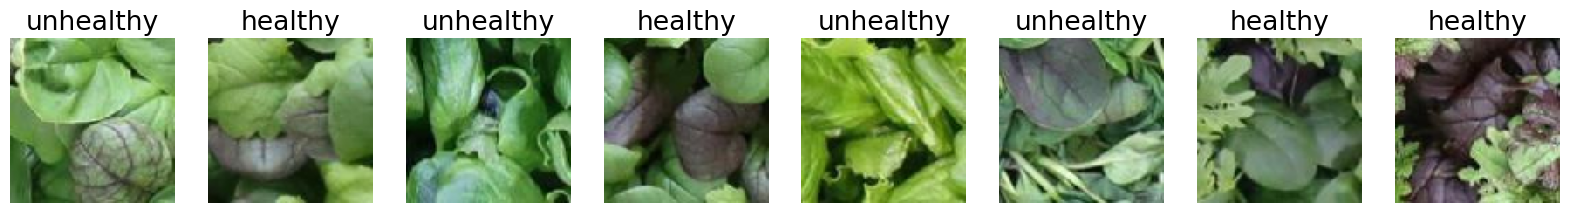

In [ ]:
# Randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

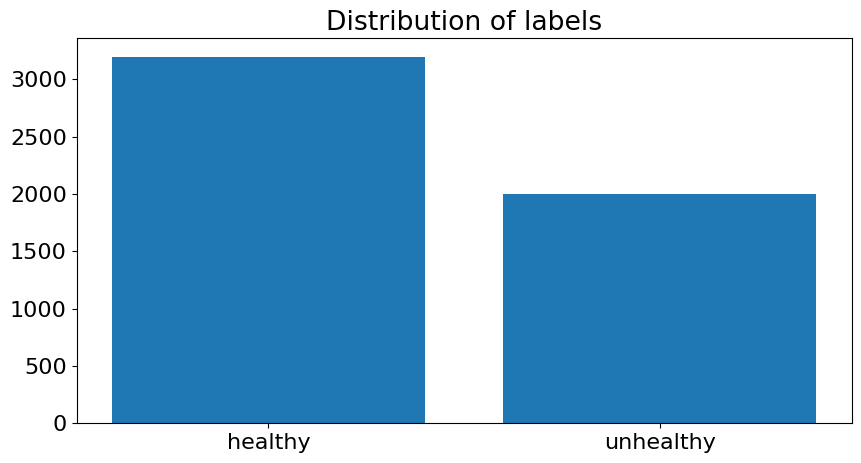

In [ ]:
# Show labels distribution

from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
#DOWNSAMPLING
# Find the indices of the healthy and unhealthy images

healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the healthy class to match the unhealthy class
num_samples = len(unhealthy_indices)

# Downsample the healthy class if necessary
if len(healthy_indices) > num_samples:
    healthy_downsampled_indices = np.random.choice(healthy_indices, size=num_samples, replace=False)
    new_indices = np.concatenate([healthy_downsampled_indices, unhealthy_indices])
else:
    new_indices = np.concatenate([healthy_indices, unhealthy_indices])

# Use the new indices to create your balanced dataset
data_balanced = data_unique[new_indices]
labels_balanced = labels_unique[new_indices]

# Function to count class instances
def count_classes(labels_to_count):
    unique, item_counts = np.unique(labels_to_count, return_counts=True)
    class_counts = dict(zip(unique, item_counts))
    return class_counts

# Count classes before downsampling
original_class_counts = count_classes(labels)
print("Original class counts:", original_class_counts)

# Count classes after downsampling
downsampled_class_counts = count_classes(labels_balanced)
print("Downsampled class counts:", downsampled_class_counts)

# Check if the classes are balanced after downsampling
if len(set(downsampled_class_counts.values())) == 1:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

In [ ]:
# UPSAMPLING
# Suppose data_unique and labels_unique are already defined

# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

# Upsample the unhealthy class
if len(unhealthy_indices) < num_samples:
    unhealthy_upsampled_indices = np.random.choice(unhealthy_indices, size=num_samples, replace=True)
    new_indices = np.concatenate([healthy_indices, unhealthy_upsampled_indices])
else:
    new_indices = np.concatenate([healthy_indices, unhealthy_indices])

# Use the new indices to create your balanced dataset
data_balanced = data_unique[new_indices]
labels_balanced = labels_unique[new_indices]

# Function to count class instances
def count_classes(labels_to_count):
    unique, item_counts = np.unique(labels_to_count, return_counts=True)
    class_counts = dict(zip(unique, item_counts))
    return class_counts

# Count classes before upsampling
original_class_counts = count_classes(labels_unique)
print("Original class counts:", original_class_counts)

# Count classes after upsampling
upsampled_class_counts = count_classes(labels_balanced)
print("Upsampled class counts:", upsampled_class_counts)

# Check if the classes are balanced after upsampling
if len(set(upsampled_class_counts.values())) == 1:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

# Assume that 'data_unique' is a Numpy array of images and 'labels_unique' are the corresponding labels
# Use the indices of the upsampled 'unhealthy' class to get the images to be augmented
upsampled_unhealthy_images = data_unique[unhealthy_upsampled_indices]




Original class counts: {'healthy': 3060, 'unhealthy': 1789}
Upsampled class counts: {'healthy': 3060, 'unhealthy': 3060}
The classes are balanced.


In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_balanced]
one_hot_labels = np.array(numeric_labels)

print(len(one_hot_labels))
print(len(data_balanced))

6120
6120


#DATA SET SPLITTING

In [ ]:
# Split the data into train_val and test sets with stratification to ensure that the distribution of labels is the same in both sets
train_val_data, test_data, train_val_labels, test_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)

# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=train_val_labels)

# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)


(4284, 96, 96, 3) (4284,)
(918, 96, 96, 3) (918,)
(918, 96, 96, 3) (918,)


#VGG 16 MODEL

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)


input_shape = (96, 96, 3)
epochs = 200

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [ ]:
import tensorflow.keras.layers as tfkl

preprocessing = tf.keras.Sequential([
    tfkl.Rescaling(1./255),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.2),
    tfkl.RandomContrast(0.2),
    tfkl.RandomTranslation(0.2, 0.2),
], name='preprocessing')

# Use the supernet as feature extractor
supernet.trainable = False


inputs = tfk.Input(shape=(96,96,3))

preprocessing = preprocessing(inputs)

x = supernet(preprocessing)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=1, activation='sigmoid', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

In [ ]:
# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()


for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)


tl_callbacks = create_folders_and_callbacks(model_name = 'aug_transfer_learning_balanced_VGG')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_8 (Dropout)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0     

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = train_data,
    y= train_labels,
    epochs = epochs,
    validation_data = (val_data, val_labels),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
134/134 [==============================] - 9s 48ms/step - loss: 0.6606 - accuracy: 0.6342 - precision_4: 0.6357 - recall_4: 0.6289 - val_loss: 0.5891 - val_accuracy: 0.6732 - val_precision_4: 0.7033 - val_recall_4: 0.5991
Epoch 2/200
134/134 [==============================] - 5s 36ms/step - loss: 0.6060 - accuracy: 0.6774 - precision_4: 0.6870 - recall_4: 0.6517 - val_loss: 0.5695 - val_accuracy: 0.6765 - val_precision_4: 0.6761 - val_recall_4: 0.6776
Epoch 3/200
134/134 [==============================] - 6s 42ms/step - loss: 0.5866 - accuracy: 0.6786 - precision_4: 0.6893 - recall_4: 0.6503 - val_loss: 0.5612 - val_accuracy: 0.6906 - val_precision_4: 0.6797 - val_recall_4: 0.7211
Epoch 4/200
134/134 [==============================] - 5s 40ms/step - loss: 0.5816 - accuracy: 0.6919 - precision_4: 0.7110 - recall_4: 0.6466 - val_loss: 0.5503 - val_accuracy: 0.6874 - val_precision_4: 0.6799 - val_recall_4: 0.7081
Epoch 5/200
134/134 [==============================] - 6s 41ms/s

KeyboardInterrupt: ignored

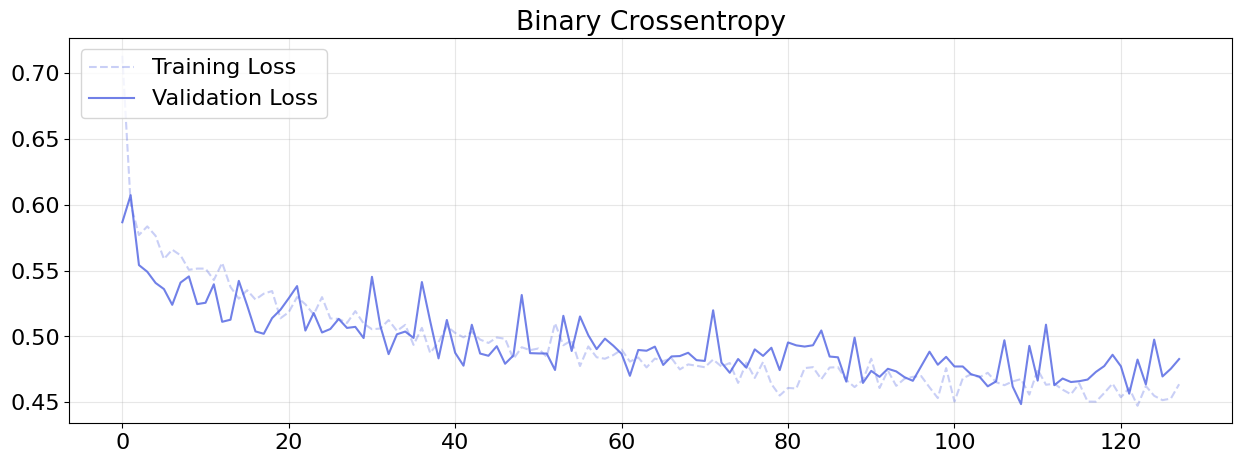

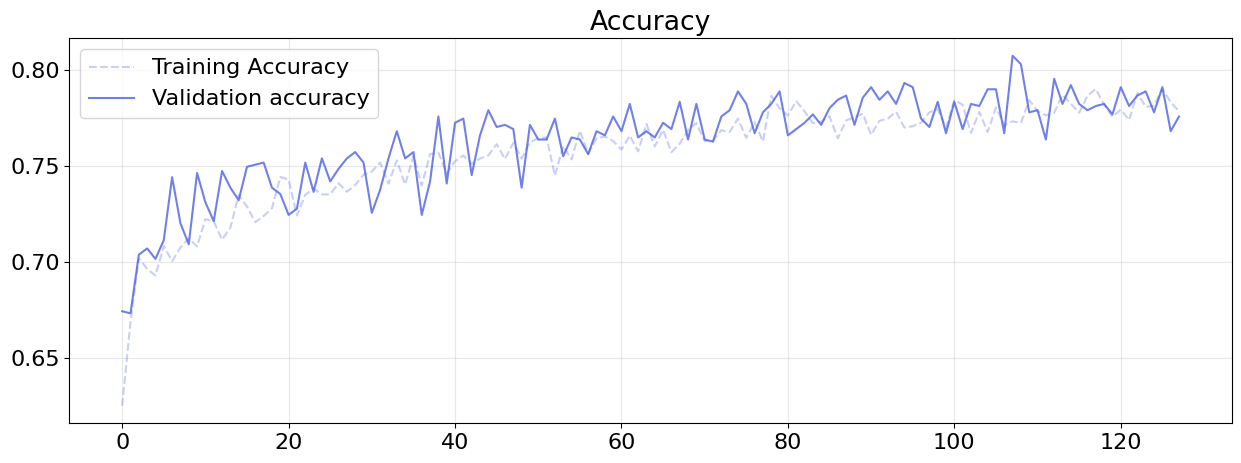

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('VGG16_model')

In [ ]:
# Re-load the model after transfer learning
tl_model = tfk.models.load_model('VGG16_model')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0     

In [ ]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0       

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = train_data,
    y= train_labels,
    epochs = epochs,
    validation_data = (val_data, val_labels),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)]
).history

Epoch 1/200
134/134 [==============================] - 11s 51ms/step - loss: 0.6418 - accuracy: 0.6431 - precision_1: 0.6446 - recall_1: 0.6377 - val_loss: 0.6117 - val_accuracy: 0.6275 - val_precision_1: 0.5857 - val_recall_1: 0.8715
Epoch 2/200
134/134 [==============================] - 6s 49ms/step - loss: 0.5613 - accuracy: 0.6975 - precision_1: 0.7065 - recall_1: 0.6755 - val_loss: 0.5123 - val_accuracy: 0.7266 - val_precision_1: 0.7600 - val_recall_1: 0.6623
Epoch 3/200
134/134 [==============================] - 6s 47ms/step - loss: 0.5284 - accuracy: 0.7353 - precision_1: 0.7447 - recall_1: 0.7162 - val_loss: 0.5137 - val_accuracy: 0.7342 - val_precision_1: 0.7541 - val_recall_1: 0.6950
Epoch 4/200
134/134 [==============================] - 7s 52ms/step - loss: 0.5135 - accuracy: 0.7381 - precision_1: 0.7429 - recall_1: 0.7283 - val_loss: 0.4703 - val_accuracy: 0.7614 - val_precision_1: 0.7105 - val_recall_1: 0.8824
Epoch 5/200
134/134 [==============================] - 6s 47ms/

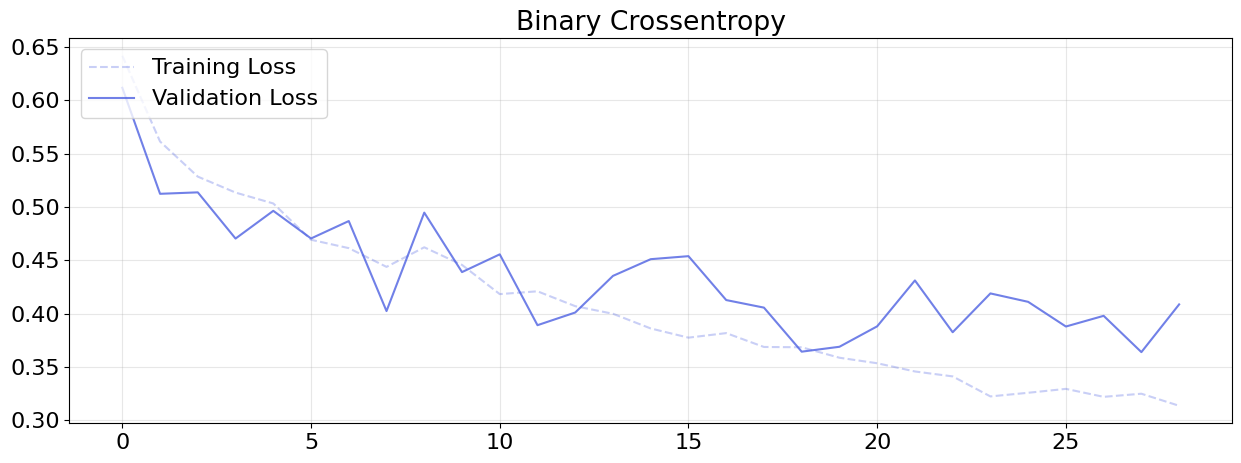

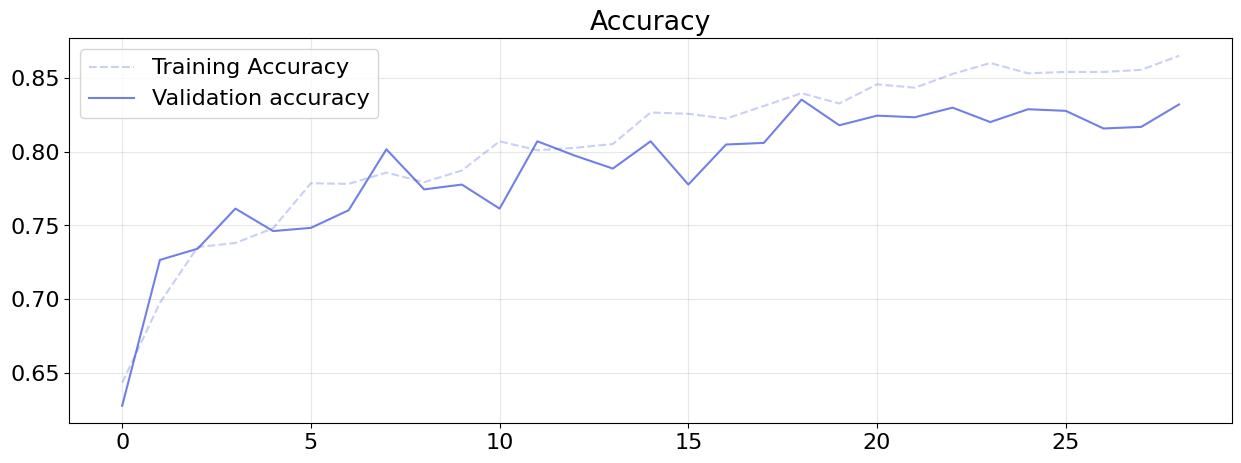

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('VGG16_model_fine_tuned')


In [ ]:

# Re-load the model after fine tuning
tl_model = tfk.models.load_model('VGG16_model_fine_tuned')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0     

In [ ]:
# Assign the evaluation results to metrics varables
loss, accuracy, precision, recall = tl_model.evaluate(test_data, test_labels)

# Print the metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")



29/29 [==============================] - 1s 30ms/step - loss: 0.3707 - accuracy: 0.8257 - precision_1: 0.8903 - recall_1: 0.7429
Loss: 0.3707190155982971
Accuracy: 0.8257080316543579
Precision: 0.8903394341468811
Recall: 0.742919385433197


In [ ]:
# Obtain the predicted values by the model
predictions = tl_model.predict(test_data)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Obtain labels as 0 or 1 for binary classification
predicted_classes = np.where(predictions > 0.5, 1, 0)


29/29 [==============================] - 1s 28ms/step
Predictions Shape: (918, 1)


[[417  42]
 [118 341]]


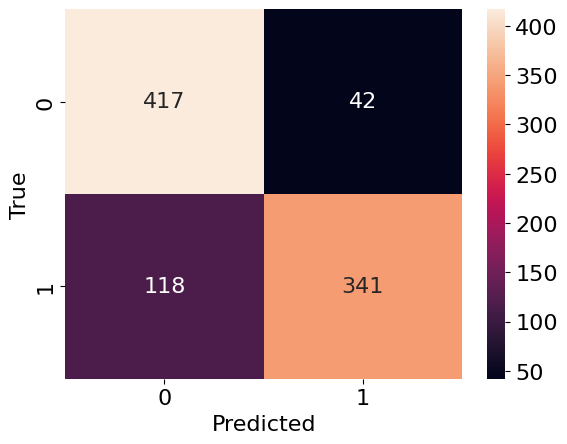

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Print the confusion matrix
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Calculate and print the classification report
report = classification_report(test_labels, predicted_classes)
print(report)


              precision    recall  f1-score   support

           0       0.78      0.91      0.84       459
           1       0.89      0.74      0.81       459

    accuracy                           0.83       918
   macro avg       0.83      0.83      0.82       918
weighted avg       0.83      0.83      0.82       918

